## Garment Manufacturing Productivity Prediction

The idea of this analysis is to predict the productivity range of the garment manufacturing process according to timelines (time series) and other parameters.

This dataset includes important attributes of the garment manufacturing process and the productivity of the employees, which have been collected manually and also validated by industry experts.
The garment industry is one of the key examples of the industrial globalisation of this modern era. It is a highly labour-intensive industry with lots of manual processes. Satisfying the huge global demand for garment products is mostly dependent on the production and delivery performance of the employees in the garment manufacturing companies.

Variable Information
01	**date**			:	Date in MM-DD-YYYY  
02	**day**			:	Day of the Week  
03	**quarter**			:	A portion of the month. A month was divided into four quarters  
04	**department**		:	Associated department with the instance  
05	**team_no**			:	Associated team number with the instance  
06	**no_of_workers**		:	Number of workers in each team  
07	**no_of_style_change**	:	Number of changes in the style of a particular product  
08	**targeted_productivity**	:	Targeted productivity set by the Authority for each team for each day.  
09	**smv**		:	Standard Minute Value, it is the allocated time for a task  
10	**wip**			:	Work in progress. Includes the number of unfinished items for products  
11	**over_time**		:	Represents the amount of overtime by each team in minutes  
12	**incentive**		:	Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.  
13	**idle_time**		:	The amount of time when the production was interrupted due to several reasons  
14	**idle_men**		:	The number of workers who were idle due to production interruption  
15	**actual_productivity**	:	The actual % of productivity that was delivered by the workers. It ranges from 0-1.  

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

%matplotlib inline
sns.set_palette('deep')

In [116]:
# reading data

df = pd.read_csv('garments_worker_productivity.csv')
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [118]:
# Checking Percentage of missing values
NAN = [(c, df [ c ].isna( ).mean( )*100) for c in df]
NAN = pd.DataFrame(NAN, columns = ['column_name', 'percentage'])
print(NAN)

              column_name  percentage
0                    date    0.000000
1                 quarter    0.000000
2              department    0.000000
3                     day    0.000000
4                    team    0.000000
5   targeted_productivity    0.000000
6                     smv    0.000000
7                     wip   42.272348
8               over_time    0.000000
9               incentive    0.000000
10              idle_time    0.000000
11               idle_men    0.000000
12     no_of_style_change    0.000000
13          no_of_workers    0.000000
14    actual_productivity    0.000000


In [119]:
unique_departments = df[df['wip'].isna()]['department'].unique()
unique_departments

array(['finishing ', 'finishing'], dtype=object)

In [120]:
# removing extra spaces

df.department = df.department.str.strip()

In [121]:
unique_departments = df[df['wip'].isna()]['department'].unique()
unique_departments

array(['finishing'], dtype=object)

In [122]:
# N/A values are only in finishing category. It would be replaced with 0

df.wip = df.wip.fillna(0)

In [123]:
# renaming department

df.department = df.department.replace({'sweing': 'sewing'})

In [124]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,687.228070,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1514.582341,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,586.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    1197 non-null   float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [126]:
df.date = pd.to_datetime(df.date)

In [127]:
df.date.unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-01-03 00:00:00', '2015-01-04 00:00:00',
 '2015-01-05 00:00:00', '2015-01-06 00:00:00', '2015-01-07 00:00:00',
 '2015-01-08 00:00:00', '2015-01-10 00:00:00', '2015-01-11 00:00:00',
 '2015-01-12 00:00:00', '2015-01-13 00:00:00', '2015-01-14 00:00:00',
 '2015-01-15 00:00:00', '2015-01-17 00:00:00', '2015-01-18 00:00:00',
 '2015-01-19 00:00:00', '2015-01-20 00:00:00', '2015-01-21 00:00:00',
 '2015-01-22 00:00:00', '2015-01-24 00:00:00', '2015-01-25 00:00:00',
 '2015-01-26 00:00:00', '2015-01-27 00:00:00', '2015-01-28 00:00:00',
 '2015-01-29 00:00:00', '2015-01-31 00:00:00', '2015-02-01 00:00:00',
 '2015-02-02 00:00:00', '2015-02-03 00:00:00', '2015-02-04 00:00:00',
 '2015-02-05 00:00:00', '2015-02-07 00:00:00', '2015-02-08 00:00:00',
 '2015-02-09 00:00:00', '2015-02-10 00:00:00', '2015-02-11 00:00:00',
 '2015-02-12 00:00:00', '2015-02-14 00:00:00', '2015-02-15 00:00:00',
 '2015-02-16 00:00:00', '2015-02-17 00:00:00', '2015-02-18 00:00:00',
 '20

In [128]:
df.day.unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [129]:
# there is no friday here - it should be fixed

In [130]:
df.quarter.unique()

array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5'],
      dtype=object)

In [131]:
# there is an error here - quarters should be fixed

In [132]:
df.department.unique()

array(['sewing', 'finishing'], dtype=object)

In [133]:
sorted(df['team'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [134]:
sorted(df.targeted_productivity.unique())

[0.07, 0.35, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8]

In [135]:
df.smv.unique()

array([26.16,  3.94, 11.41, 25.9 , 28.08, 19.87, 19.31,  2.9 , 23.69,
        4.15, 11.61, 45.67, 21.98, 31.83, 12.52, 42.41, 20.79, 50.48,
        4.3 , 22.4 , 42.27, 27.13, 14.61, 51.02, 22.52, 14.89, 22.94,
       48.68, 41.19, 48.84, 26.87, 20.4 , 49.1 , 15.26, 54.56, 40.99,
       29.12,  4.08, 42.97, 15.09, 30.4 , 48.18, 20.1 , 38.09, 18.79,
       23.54, 50.89, 24.26, 20.55, 30.1 , 25.31, 10.05, 18.22,  5.13,
       29.4 , 30.33, 19.68, 21.25,  4.6 ,  3.9 , 22.53, 21.82, 27.48,
       26.66, 20.2 , 15.28, 26.82, 16.1 , 23.41, 30.48])

In [136]:
df.over_time.unique()

array([ 7080,   960,  3660,  1920,  6720,  6900,  6000,  6480,  2160,
        7200,  1440,  6600,  5640,  1560,  6300,  6540, 13800,  6975,
        7020,  6780,  4260,  6660,  4320,  6960,  2400,  3840,  4800,
        4440,  1800,  2700, 10620, 10350,  9900,  5310, 10170,  4470,
       10530, 10440,  5490,  5670,  9720, 12600, 10050, 15120, 14640,
         900, 25920, 10260,  2760,  4710,  9540,  7680,  3600,  6420,
        7980,  3240,  8220,  6930,  8460,  7350,  5400,  1620,  1980,
        2970,  7320,  5100,  3390,  1260,  3420,  8970,  4950, 10080,
        9810,  6570,  5040,  4380,  3630,  8280,  6120,  5580,  3720,
        5760,  7470, 10500,  6360,  4140,  8400, 12180,  9000, 15000,
       10770, 12000,  9360,  3060,  2520,   720,  3780, 10320,   360,
        6840,  1080,  1200,  4080,   240,  5880,  6240,  4200,  3960,
         600,  2280,  5940,  1320,  5460,  2040,  4020,  3000,  3360,
        5820,  6060,  2640,  7500,  2880,   120,  3300,     0,  3480,
        7380,  4560,

In [137]:
df.incentive.unique()

array([  98,    0,   50,   38,   45,   34,   44,   63,   56,   40,   60,
         26,   75,   23,   35,   69,   88,   30,   54,   37,   70,   27,
         21,   24,   94,   29,   81,   55,  119,   90,  113,   46,  100,
         53,   93,   49,  138,   33,   32,   62,   65,  960, 1080, 2880,
       3600, 1440, 1200,   25], dtype=int64)

In [138]:
sorted(df.idle_time.unique())

[0.0, 2.0, 3.5, 4.0, 4.5, 5.0, 6.5, 8.0, 90.0, 150.0, 270.0, 300.0]

In [139]:
sorted(df.idle_men.unique())

[0, 10, 15, 20, 25, 30, 35, 37, 40, 45]

In [140]:
df.no_of_style_change.unique()

array([0, 1, 2], dtype=int64)

In [141]:
df.no_of_workers.unique()

array([59. ,  8. , 30.5, 56. , 57.5, 55. , 54. , 18. , 60. , 12. , 20. ,
       17. , 56.5, 54.5, 29.5, 31.5, 31. , 55.5, 58. , 10. , 16. , 32. ,
       58.5, 15. ,  5. , 57. , 53. , 51.5,  2. ,  9. ,  7. , 19. , 28. ,
       34. , 89. , 14. , 25. , 52. ,  4. , 21. , 35. , 51. , 33. , 11. ,
       33.5, 22. , 26. , 27. , 59.5, 50. , 44. , 49. , 47. , 48. , 42. ,
       24. , 45. , 46. , 39. , 38. ,  6. ])

In [142]:
# Number of workers should be rounded and turned to integer

df['no_of_workers'] = df['no_of_workers'].round()
df['no_of_workers'] = df['no_of_workers'].astype(int)

In [143]:
df.no_of_workers.unique()

array([59,  8, 30, 56, 58, 55, 54, 18, 60, 12, 20, 17, 32, 31, 10, 16, 15,
        5, 57, 53, 52,  2,  9,  7, 19, 28, 34, 89, 14, 25,  4, 21, 35, 51,
       33, 11, 22, 26, 27, 50, 44, 49, 47, 48, 42, 24, 45, 46, 39, 38,  6])

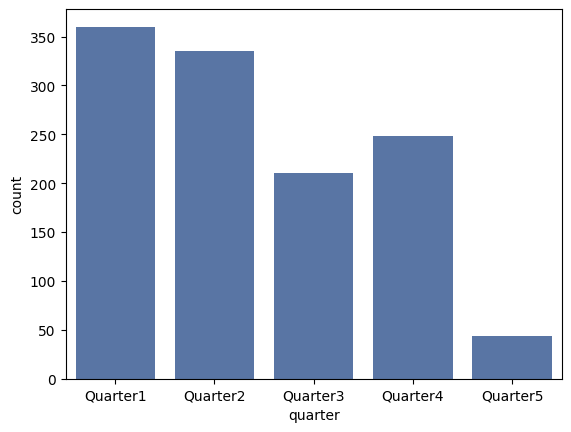

In [144]:
# Checking distribution

sns.countplot(data = df, x='quarter')
plt.show()

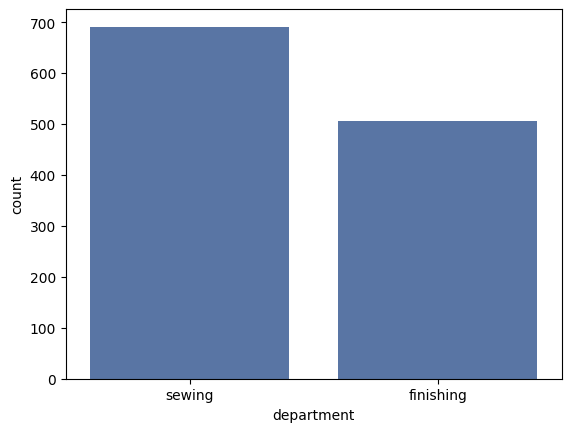

In [145]:
# Checking distribution

sns.countplot(data = df, x='department')
plt.show()

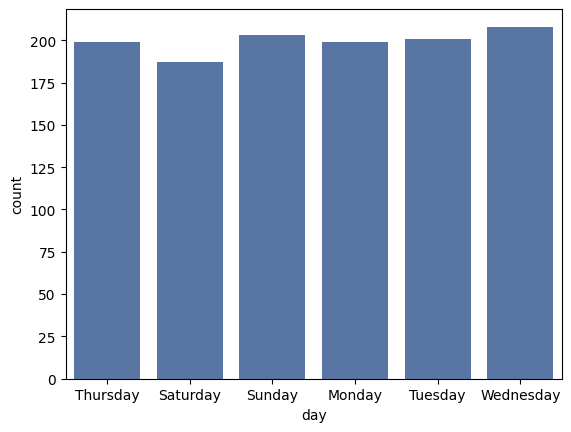

In [146]:
# Checking distribution

sns.countplot(data = df, x='day')
plt.show()

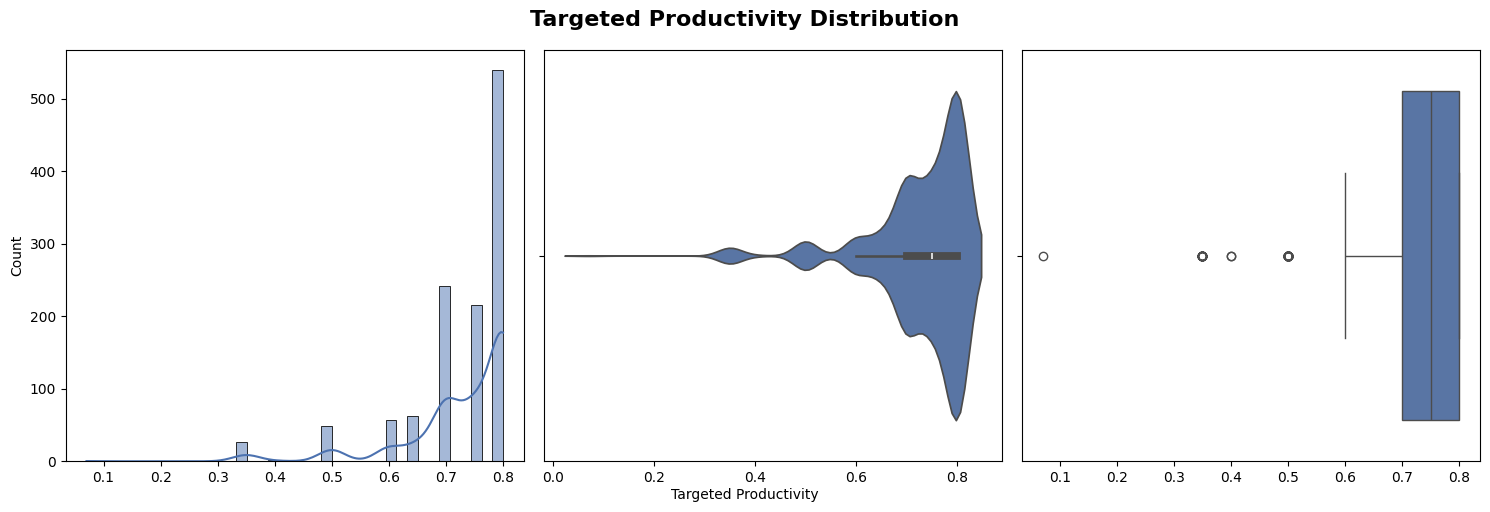

In [147]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='targeted_productivity', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['targeted_productivity'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['targeted_productivity'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Targeted Productivity Distribution', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Targeted Productivity', ha='center', va='center')

plt.tight_layout()
plt.show()


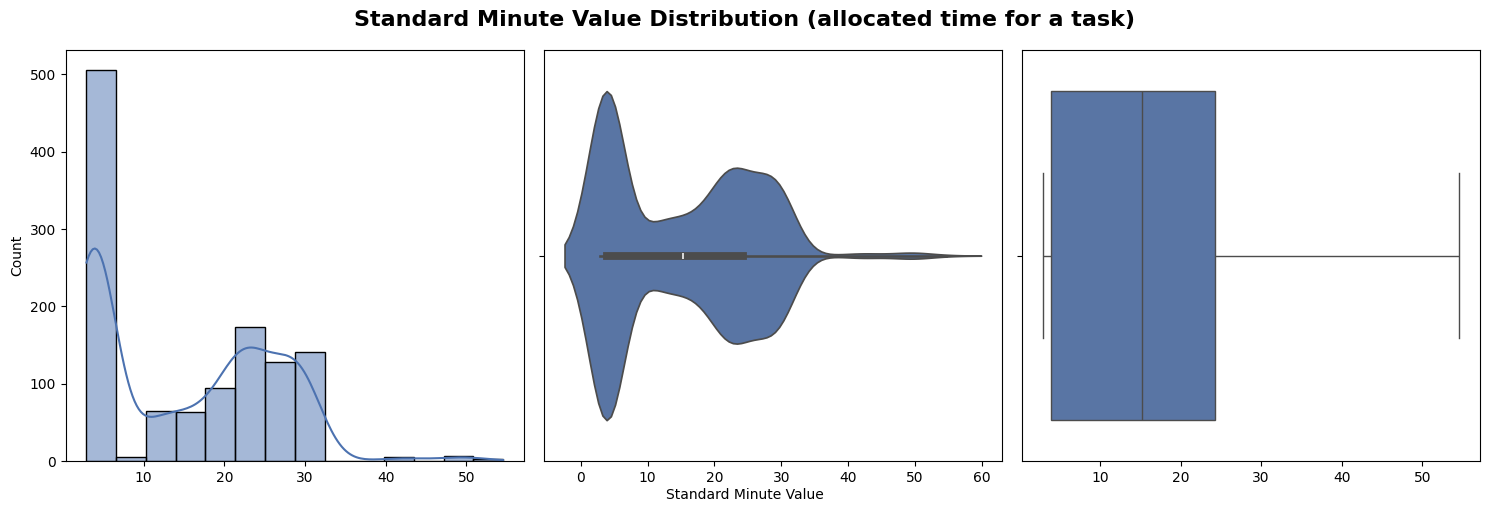

In [148]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='smv', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['smv'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['smv'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Standard Minute Value Distribution (allocated time for a task)', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Standard Minute Value', ha='center', va='center')

plt.tight_layout()
plt.show()

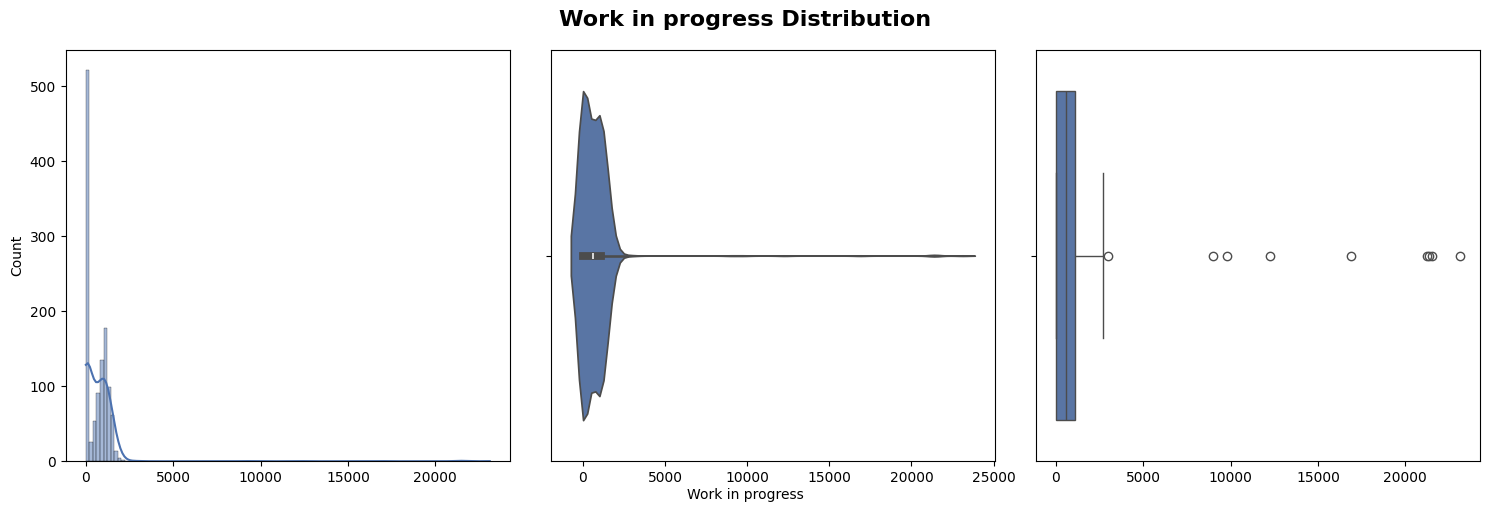

In [149]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='wip', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['wip'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['wip'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Work in progress Distribution', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Work in progress', ha='center', va='center')

plt.tight_layout()
plt.show()

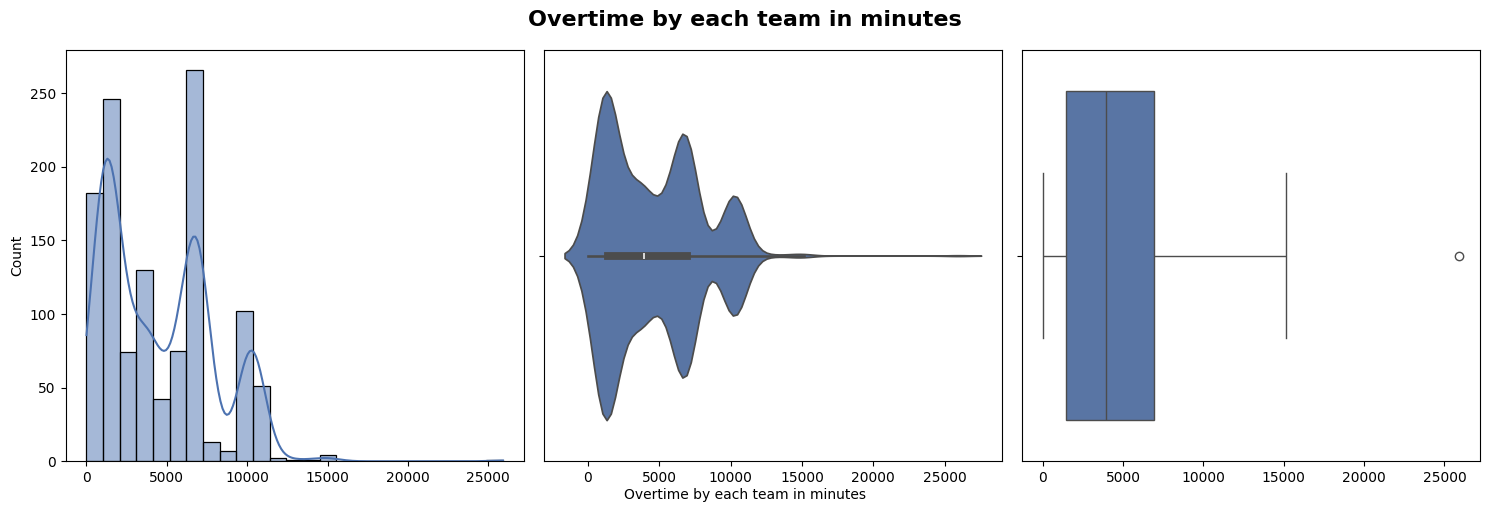

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='over_time', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['over_time'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['over_time'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Overtime by each team in minutes', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Overtime by each team in minutes', ha='center', va='center')

plt.tight_layout()
plt.show()

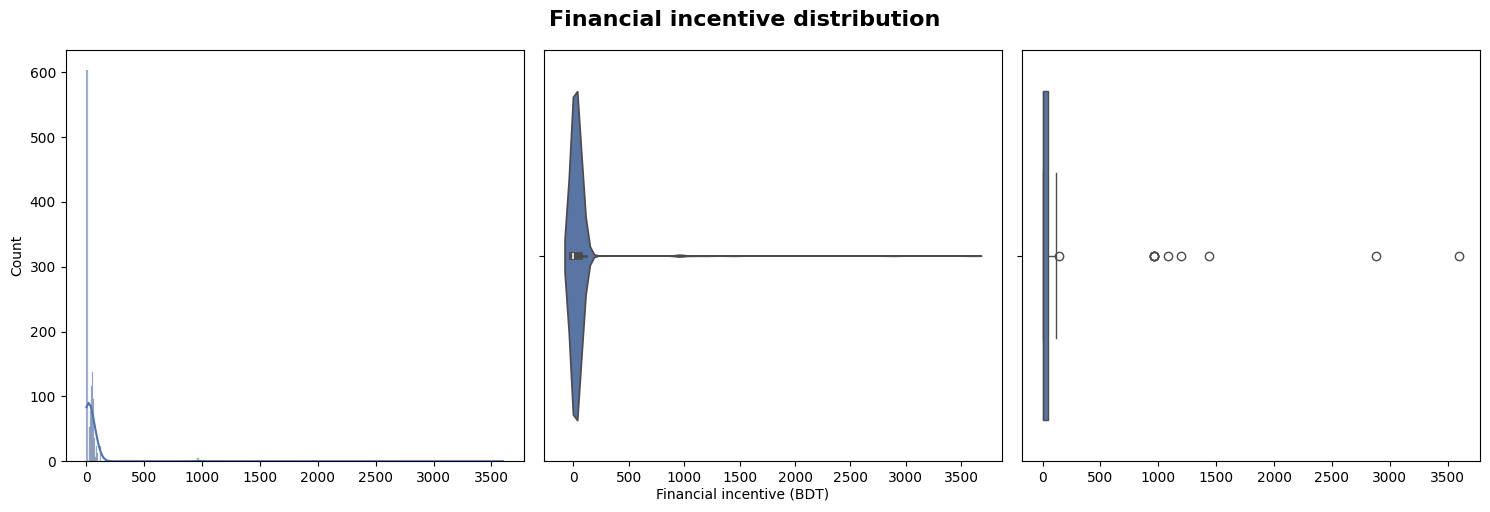

In [151]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='incentive', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['incentive'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['incentive'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Financial incentive distribution', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Financial incentive (BDT) ', ha='center', va='center')

plt.tight_layout()
plt.show()

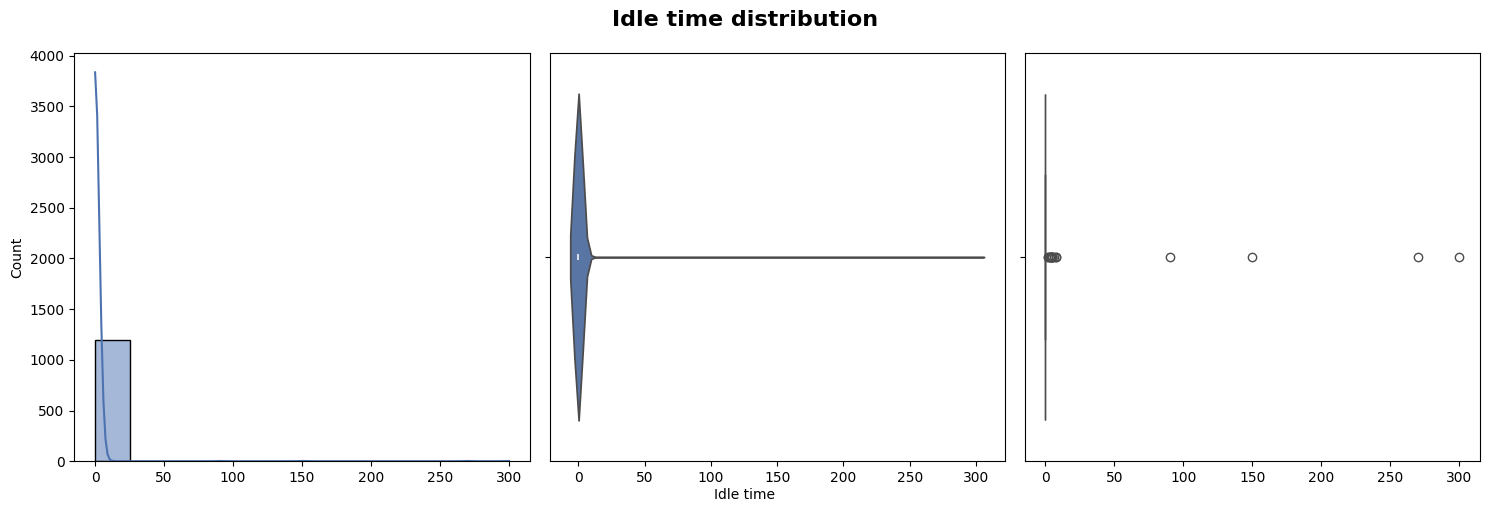

In [152]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='idle_time', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['idle_time'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['idle_time'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Idle time distribution', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Idle time', ha='center', va='center')

plt.tight_layout()
plt.show()

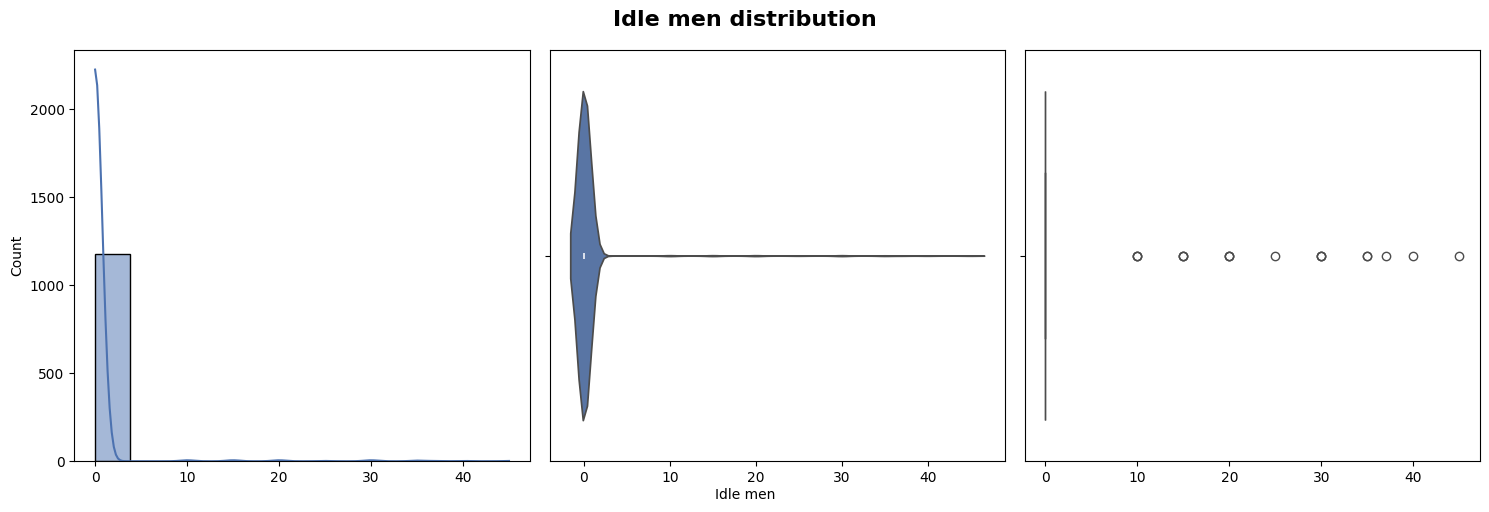

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='idle_men', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['idle_men'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['idle_men'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Idle men distribution', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Idle men', ha='center', va='center')

plt.tight_layout()
plt.show()

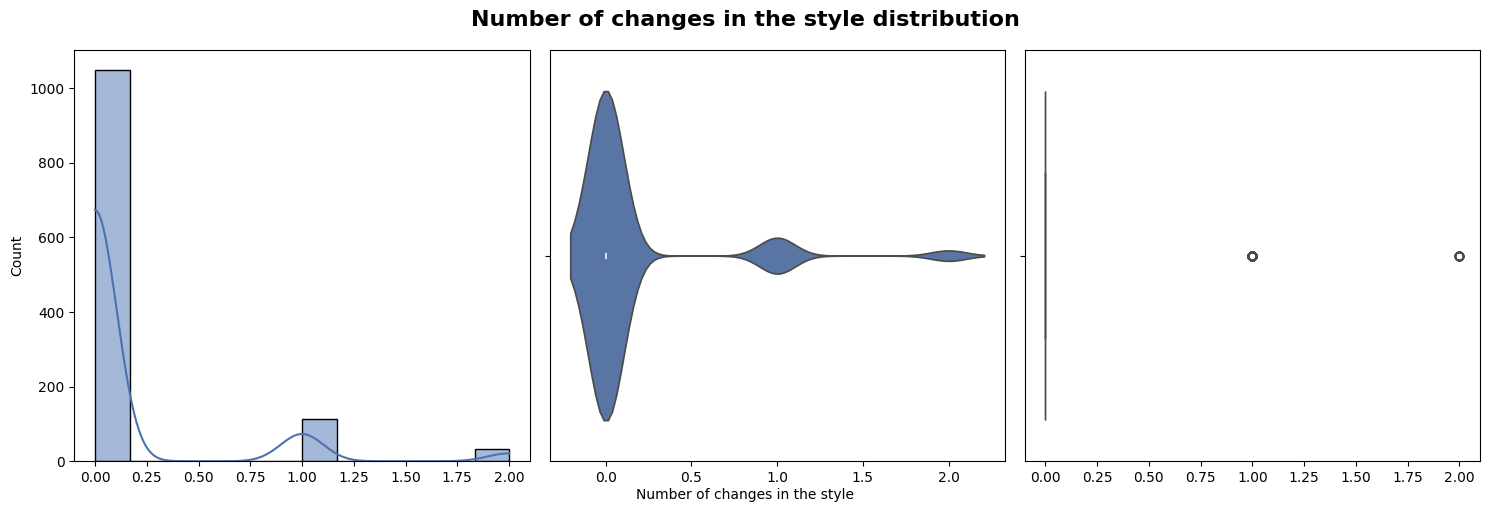

In [154]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='no_of_style_change', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['no_of_style_change'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['no_of_style_change'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Number of changes in the style distribution', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Number of changes in the style', ha='center', va='center')

plt.tight_layout()
plt.show()

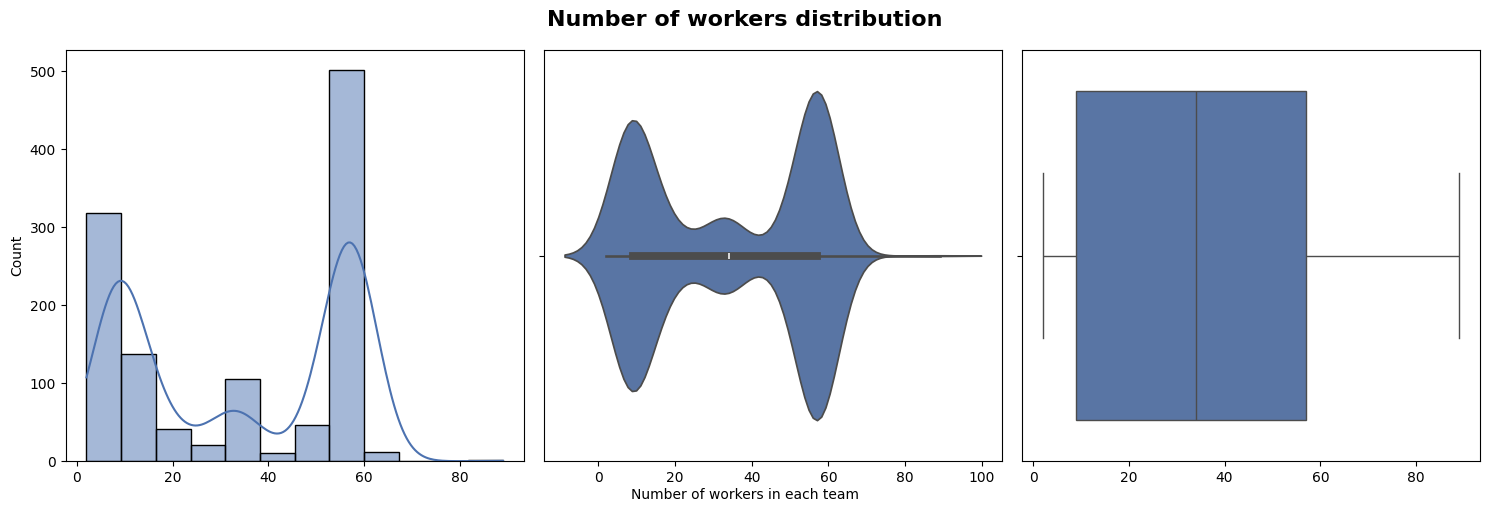

In [155]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='no_of_workers', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['no_of_workers'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['no_of_workers'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Number of workers distribution', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'Number of workers in each team', ha='center', va='center')

plt.tight_layout()
plt.show()

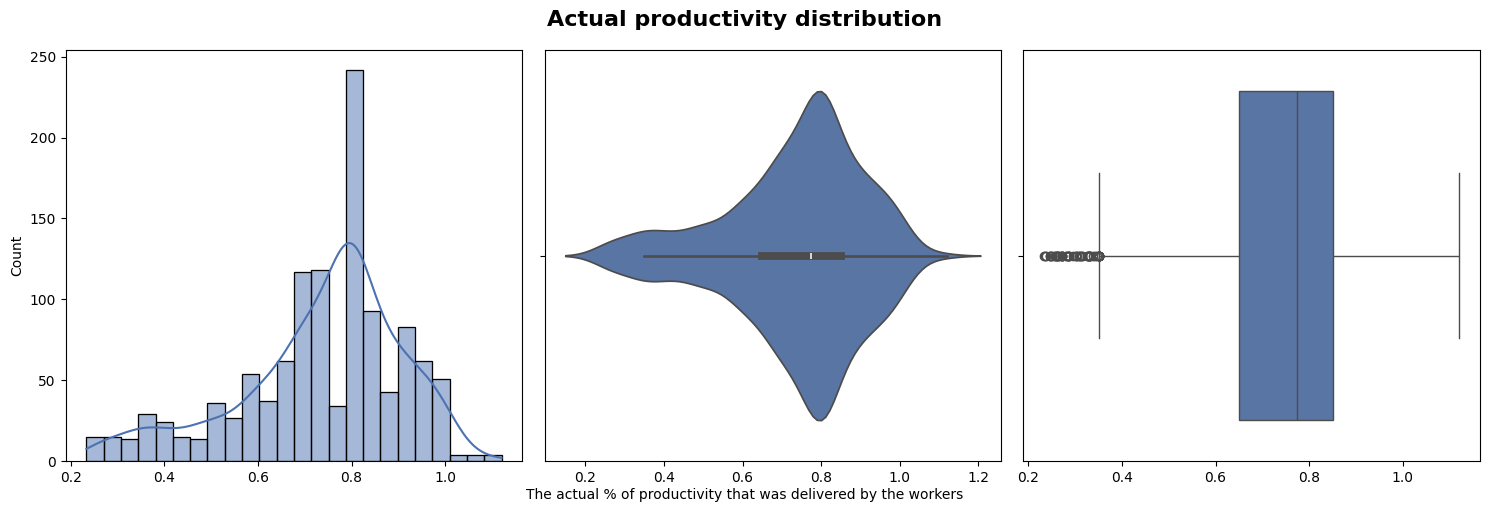

In [156]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Histogram with Kernel Density Estimation
sns.histplot(data=df, x='actual_productivity', kde=True, ax=axs[0])
axs[0].set(xlabel=None) # remove x-axis label for individual plot

# Violin plot
sns.violinplot(x=df['actual_productivity'], ax=axs[1])
axs[1].set(xlabel=None) # remove x-axis label for individual plot

# Box plot
sns.boxplot(x=df['actual_productivity'], ax=axs[2])
axs[2].set(xlabel=None) # remove x-axis label for individual plot

# Set common labels
fig.suptitle('Actual productivity distribution', fontsize=16, fontweight='bold')
fig.text(0.5, 0.01, 'The actual % of productivity that was delivered by the workers', ha='center', va='center')

plt.tight_layout()
plt.show()

In [157]:
# Bivariate analysis

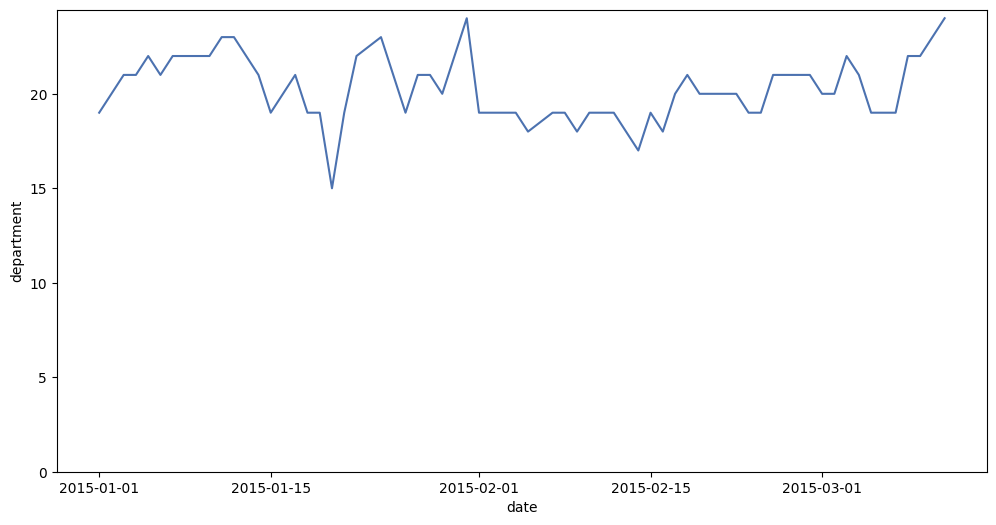

In [158]:
plt.figure(figsize=(12, 6))  # Makes the plot wider. You can adjust the numbers as needed.
df_count = df.groupby('date')['department'].count().reset_index()
sns.lineplot(data = df_count, x = 'date', y='department')
plt.ylim(ymin=0)  # Sets the y-axis to start from zero
plt.show()

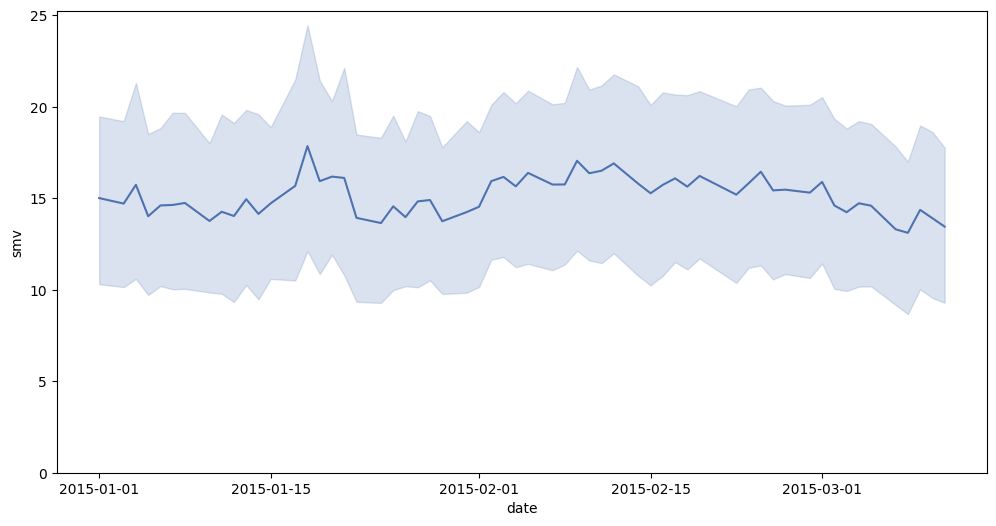

In [159]:
plt.figure(figsize=(12, 6))  # Makes the plot wider. You can adjust the numbers as needed.
sns.lineplot(data = df, x = 'date', y='smv')
plt.ylim(ymin=0)  # Sets the y-axis to start from zero
plt.show()

In [160]:
# to check correlation between smv and number of departments

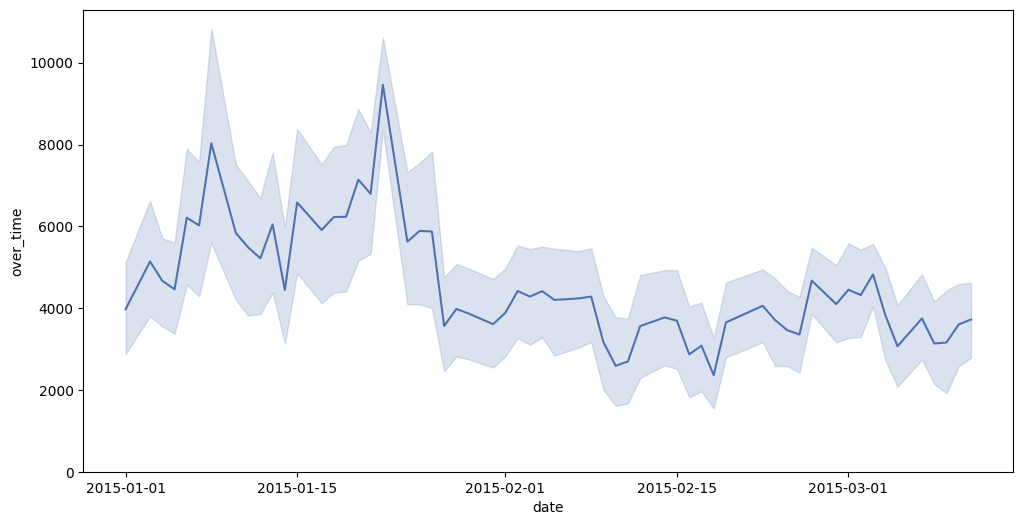

In [161]:
plt.figure(figsize=(12, 6))  # Makes the plot wider. You can adjust the numbers as needed.
sns.lineplot(data = df, x = 'date', y='over_time')
plt.ylim(ymin=0)  # Sets the y-axis to start from zero
plt.show()

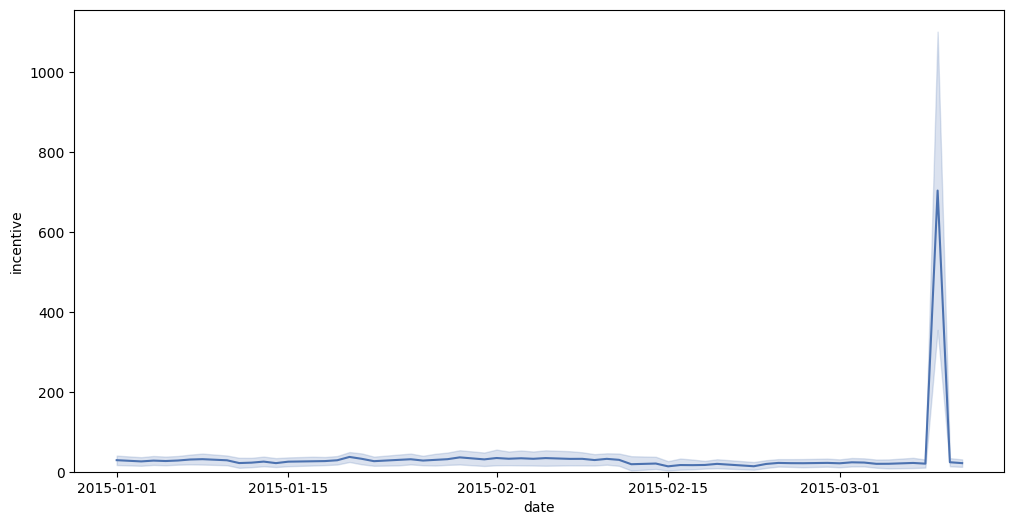

In [162]:
plt.figure(figsize=(12, 6))  # Makes the plot wider. You can adjust the numbers as needed.
sns.lineplot(data = df, x = 'date', y='incentive')
plt.ylim(ymin=0)  # Sets the y-axis to start from zero
plt.show()

In [163]:
# there is a big spike in incentives in the end of march 2015

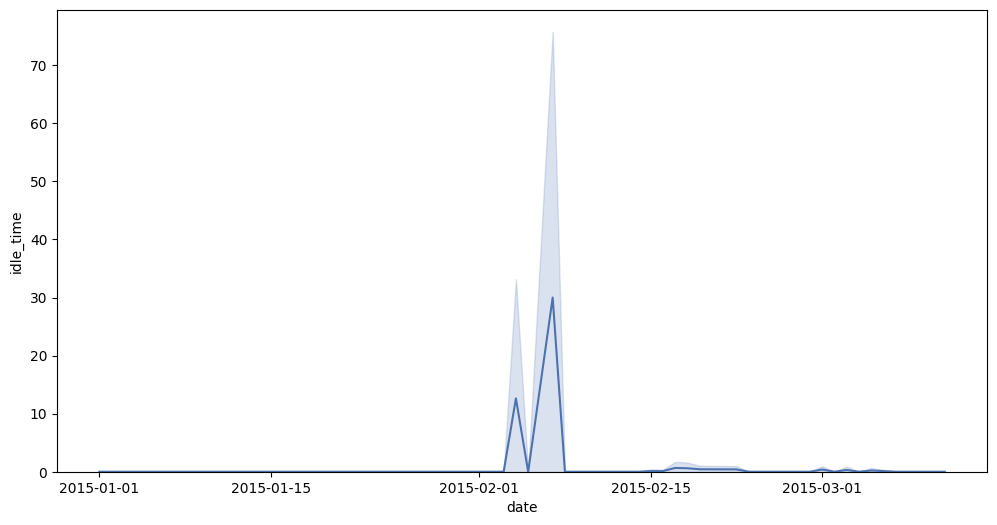

In [164]:
plt.figure(figsize=(12, 6))  # Makes the plot wider. You can adjust the numbers as needed.
sns.lineplot(data = df, x = 'date', y='idle_time')
plt.ylim(ymin=0)  # Sets the y-axis to start from zero
plt.show()

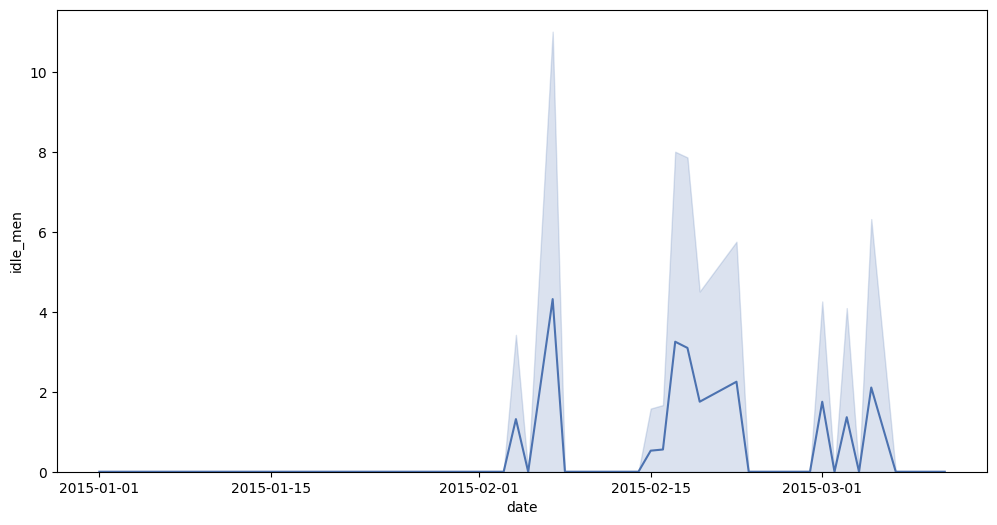

In [165]:
plt.figure(figsize=(12, 6))  # Makes the plot wider. You can adjust the numbers as needed.
sns.lineplot(data = df, x = 'date', y='idle_men')
plt.ylim(ymin=0)  # Sets the y-axis to start from zero
plt.show()

In [166]:
# there is only one correlation between idle time and amount of idle men in february 2015. Latest spikes in amount of interrupted nem cause almost no effect on idle time overall

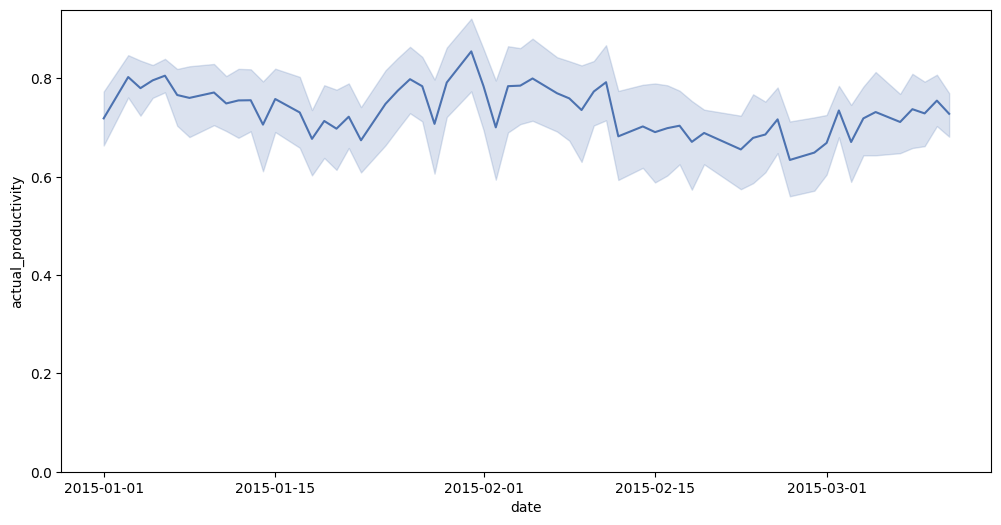

In [167]:
plt.figure(figsize=(12, 6))  # Makes the plot wider. You can adjust the numbers as needed.
sns.lineplot(data = df, x = 'date', y='actual_productivity')
plt.ylim(ymin=0)  # Sets the y-axis to start from zero
plt.show()

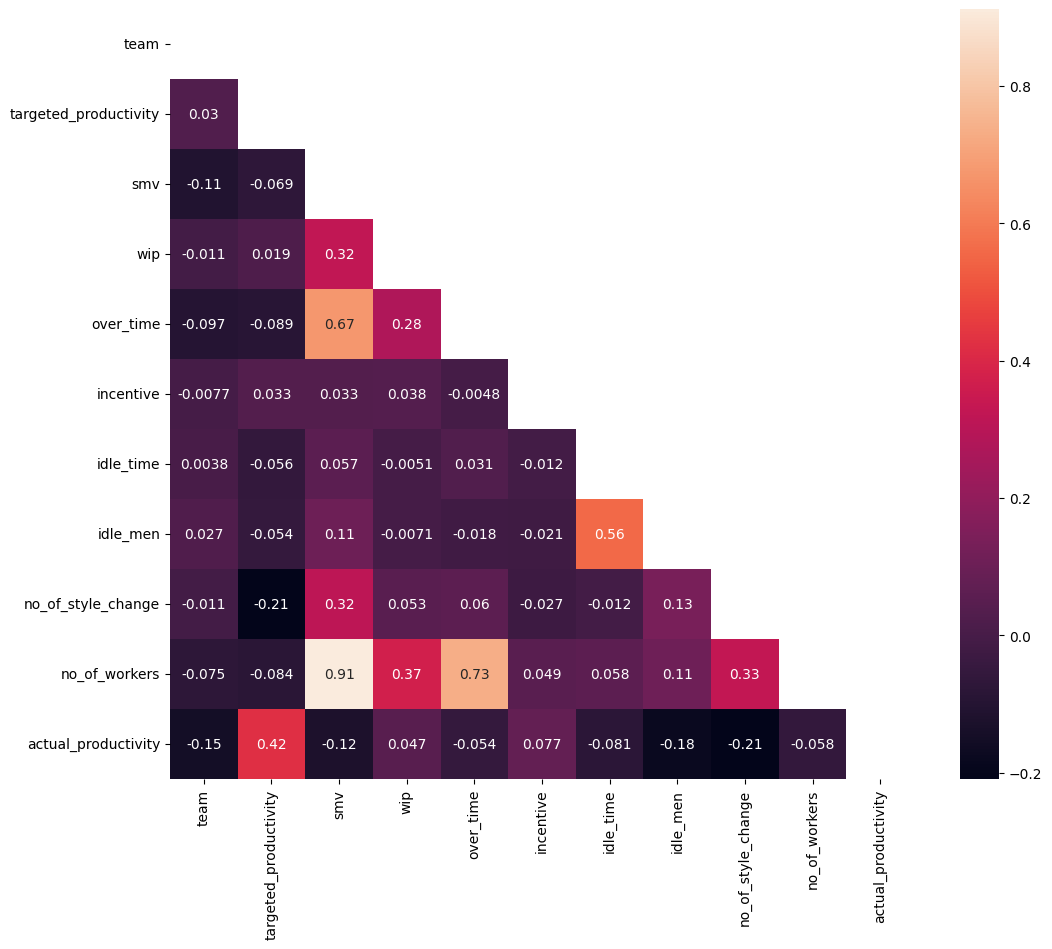

In [168]:
# Checking correlation
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only = True)
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(corr, annot = True, mask=matrix)
plt.show()

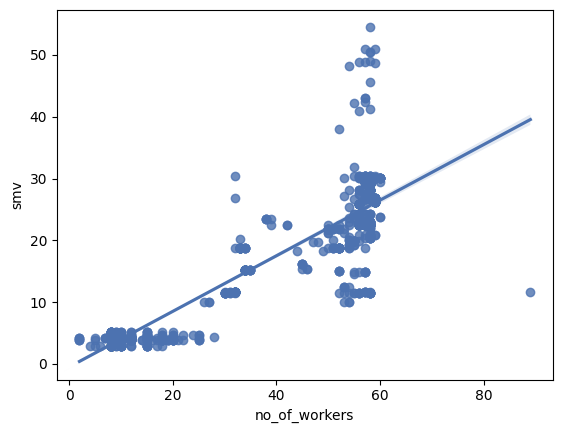

In [169]:
sns.regplot(data = df, x = 'no_of_workers', y = 'smv')
plt.show()

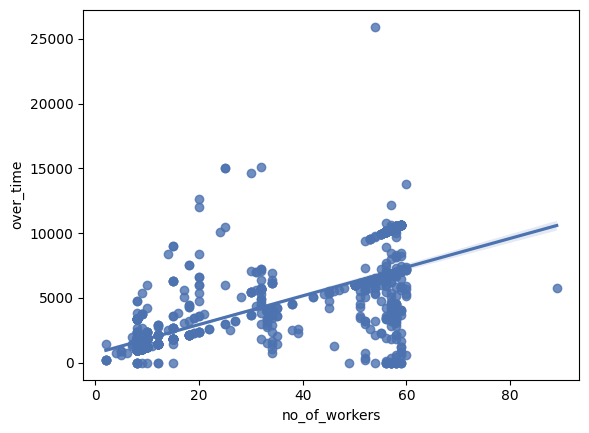

In [170]:
sns.regplot(data = df, x = 'no_of_workers', y = 'over_time')
plt.show()

In [171]:
# Data preprocessing

In [172]:
# Detecting outliers using z_score

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_indices = set()
for col in numeric_cols:
    z_scores = np.abs(stats.zscore(df[col]))
    threshold = 3
    outlier_indices.update(df[z_scores > threshold].index.tolist())

# Deleting outliers

df = df.drop(outlier_indices, errors='ignore')


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1091 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1091 non-null   datetime64[ns]
 1   quarter                1091 non-null   object        
 2   department             1091 non-null   object        
 3   day                    1091 non-null   object        
 4   team                   1091 non-null   int64         
 5   targeted_productivity  1091 non-null   float64       
 6   smv                    1091 non-null   float64       
 7   wip                    1091 non-null   float64       
 8   over_time              1091 non-null   int64         
 9   incentive              1091 non-null   int64         
 10  idle_time              1091 non-null   float64       
 11  idle_men               1091 non-null   int64         
 12  no_of_style_change     1091 non-null   int64         
 13  no_of_wo

In [174]:
# encoding date

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
del df['date']

In [175]:
# encoding quarter of the month and department

df = pd.get_dummies(df, columns=['quarter'])
df = pd.get_dummies(df, columns=['department'])

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1091 entries, 0 to 1196
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   day                    1091 non-null   int32  
 1   team                   1091 non-null   int64  
 2   targeted_productivity  1091 non-null   float64
 3   smv                    1091 non-null   float64
 4   wip                    1091 non-null   float64
 5   over_time              1091 non-null   int64  
 6   incentive              1091 non-null   int64  
 7   idle_time              1091 non-null   float64
 8   idle_men               1091 non-null   int64  
 9   no_of_style_change     1091 non-null   int64  
 10  no_of_workers          1091 non-null   int32  
 11  actual_productivity    1091 non-null   float64
 12  year                   1091 non-null   int32  
 13  month                  1091 non-null   int32  
 14  day_of_week            1091 non-null   int32  
 15  day_of_ye

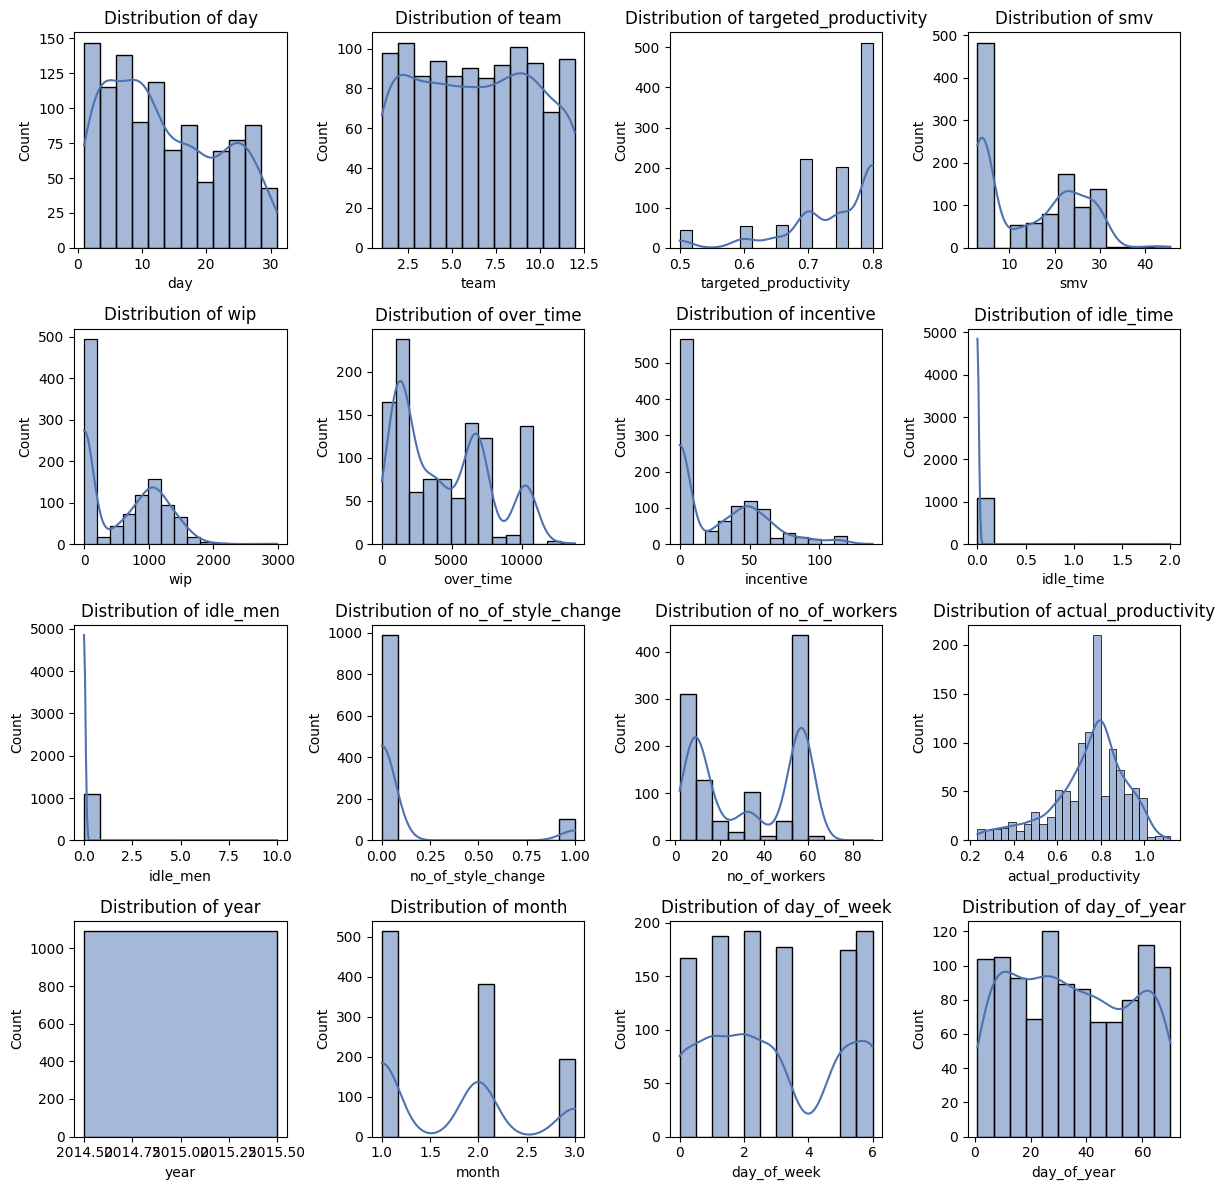

In [177]:
# Checking dataframe for skeweness
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

n = len(num_cols)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))

for i, col in enumerate(num_cols):
    r, c = i // ncols, i % ncols
    sns.histplot(data=df, x=col, kde=True, ax=axs[r, c])
    axs[r, c].set_title('Distribution of ' + col)

# Remove empty subplots
for j in range(i+1, nrows*ncols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()


In [178]:
# Feature transformation

# List of columns to transform
cols_to_transform = ['targeted_productivity', 'smv', 'over_time', 'incentive', 'no_of_style_change', 'no_of_workers', 'wip', 'idle_time', 'idle_men']

# Apply log transformation
for col in cols_to_transform:
    df[col] = np.log(df[col] + 1)  # Adding 1 before taking log to avoid -inf for zero values

In [179]:
df.describe()

,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,year,month,day_of_week,day_of_year
count,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.0,1091.000000,1091.000000,1091.000000
mean,13.372136,6.384968,0.553043,2.447373,3.804643,7.980416,1.893366,0.001007,0.002198,0.065439,3.246334,0.745477,2015.0,1.707608,2.868928,34.771769
std,8.636540,3.472343,0.045420,0.806411,3.424350,1.306230,1.984310,0.033261,0.072597,0.202767,0.833654,0.167705,0.0,0.751590,2.110754,20.752101
min,1.000000,1.000000,0.405465,1.360977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,0.233705,2015.0,1.000000,0.000000,1.000000
25%,6.000000,3.000000,0.530628,1.597365,0.000000,7.273093,0.000000,0.000000,0.000000,0.000000,2.302585,0.664875,2015.0,1.000000,1.000000,17.000000
50%,11.000000,6.000000,0.559616,2.778198,6.329721,8.284252,0.000000,0.000000,0.000000,0.000000,3.555348,0.799963,2015.0,2.000000,2.000000,34.000000
75%,21.000000,9.000000,0.587787,3.175551,6.988413,8.839422,3.931826,0.000000,0.000000,0.000000,4.060443,0.850502,2015.0,2.000000,5.000000,54.000000
max,31.000000,12.000000,0.587787,3.843102,8.001355,9.532496,4.934474,1.098612,2.397895,0.693147,4.499810,1.120437,2015.0,3.000000,6.000000,70.000000


In [180]:
# Defining independent and target features
X = df.drop('actual_productivity', axis=1)  # Features
y = df['actual_productivity']  # Target variable

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [181]:
# Creating a scaler object
scaler = RobustScaler()

# Data fit and transform
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [189]:
# Define the model
best_model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
best_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model and store the history
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

# Predict the values
y_test_pred = best_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R2 Score: {r2}')




Epoch 1/20
24/24 - 0s - loss: 0.1316 - 460ms/epoch - 19ms/step
Epoch 2/20
24/24 - 0s - loss: 0.0272 - 46ms/epoch - 2ms/step
Epoch 3/20
24/24 - 0s - loss: 0.0204 - 45ms/epoch - 2ms/step
Epoch 4/20
24/24 - 0s - loss: 0.0187 - 42ms/epoch - 2ms/step
Epoch 5/20
24/24 - 0s - loss: 0.0177 - 36ms/epoch - 2ms/step
Epoch 6/20
24/24 - 0s - loss: 0.0169 - 36ms/epoch - 2ms/step
Epoch 7/20
24/24 - 0s - loss: 0.0161 - 37ms/epoch - 2ms/step
Epoch 8/20
24/24 - 0s - loss: 0.0156 - 39ms/epoch - 2ms/step
Epoch 9/20
24/24 - 0s - loss: 0.0149 - 36ms/epoch - 1ms/step
Epoch 10/20
24/24 - 0s - loss: 0.0146 - 32ms/epoch - 1ms/step
Epoch 11/20
24/24 - 0s - loss: 0.0144 - 38ms/epoch - 2ms/step
Epoch 12/20
24/24 - 0s - loss: 0.0133 - 35ms/epoch - 1ms/step
Epoch 13/20
24/24 - 0s - loss: 0.0131 - 36ms/epoch - 2ms/step
Epoch 14/20
24/24 - 0s - loss: 0.0128 - 37ms/epoch - 2ms/step
Epoch 15/20
24/24 - 0s - loss: 0.0125 - 38ms/epoch - 2ms/step
Epoch 16/20
24/24 - 0s - loss: 0.0123 - 36ms/epoch - 1ms/step
Epoch 17/20
24/

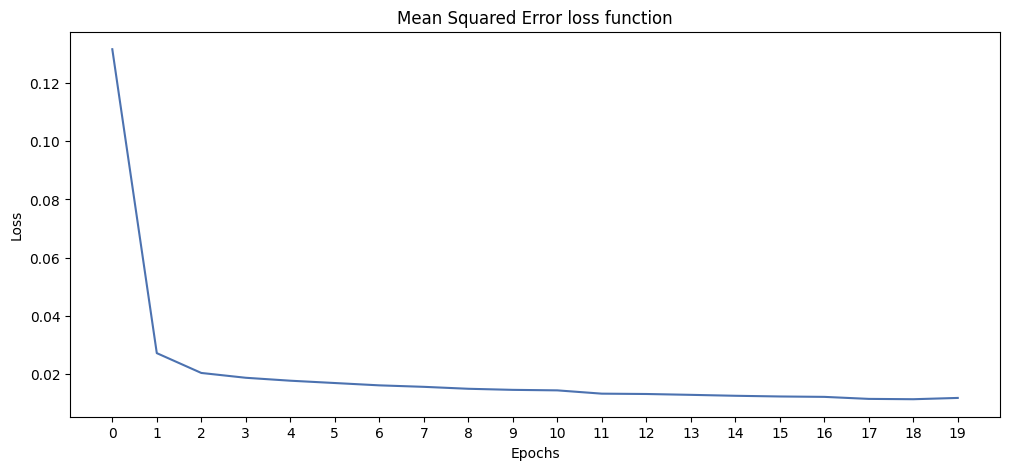

In [200]:
# Plot the loss function

plt.figure(figsize=(12, 5)) 
sns.lineplot(history.history['loss'])
plt.title('Mean Squared Error loss function')
plt.ylabel('Loss')
plt.xlabel('Epochs')


# Set x-ticks to be integers
plt.xticks(np.arange(0, len(history.history['loss']), step=1))

plt.show()

### The analysis of the garment manufacturing productivity dataset revealed some interesting insights and patterns. The main findings are:

- The targeted productivity was higher on weekdays than on weekends, and it varied across different departments and quarters.
- The actual productivity was positively correlated with the number of workers, the overtime, and the incentive, and negatively correlated with the number of style changes, the work in progress, the idle time, and the idle men.
- In conclusion, the productivity of garment manufacturing employees can be predicted with reasonable accuracy using a variety of factors, including timelines (time series), department, team number, number of workers, number of style changes, targeted productivity, standard minute value (SMV), work in progress (WIP), overtime, incentive.

The Keras model achieved the following results:- 

Mean Absolute Error (MAE): 0.12398475037769- 252
Mean Squared Error (MSE): 0.02653242808065- 1923
Root Mean Squared Error (RMSE): 0.16288777756680187
These results indicate that the model is able to predict targeted productivity with a high degree of accuracy. However, it is important to note that the model is only as good as the data it is trained on. Therefore, it is important to ensure that the data is high quality and representative of the real world.

Overall, the model provides a valuable tool for predicting the productivity of garment manufacturing employees. This information can be used to improve production planning and scheduling, as well as to identify areas where productivity can be improved.